### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-02 20:40:00.171880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 20:40:00.172531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorc

Changes from previous version: I am implementing COVID-19 classification with ProtTrans (Rostlab models) starting with the BFD

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    # print(embedding_model(input_ids)[0].shape) # Residue specific embeddings
    # print(embedding_model(input_ids)[1].shape) # Pooled embeddings - they did not recommend to use
    cls_embeddings = [] 
    residue_embeddings = []
    average_embeddings = []
    for seq_num in range(len(embedding)):
        cls = embedding[seq_num][0]

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        print(np.shape(residues))
        average = np.mean(residues, axis=0)

        cls_embeddings.append(cls)
        residue_embeddings.append(residues)
        average_embeddings.append(average)

    return np.asarray(cls_embeddings), np.asarray(average_embeddings), residue_embeddings

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
cls_embeddings, average_embeddings, residue_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(2, 9)
(7, 1024)
(5, 1024)


In [6]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [7]:
tf.__version__

'2.10.0'

# Data Formatting

In [8]:
df = pd.read_csv("../Data/CoV-AbDab_201222.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
0,EVQLVESGGGLIQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLE...
1,EVQLVQSGGGLVQPGGSLRLSCLASGLTFSSYEFNWIRQAPGKGLE...
2,QVQLVQSGAEVKRPGASVKVLCMASGYSFTNYGINWVRQAPGQGLE...
3,EVQLVQSGAEVKKPRESLKISCKGSGYNFTSYWIGWVRQMPGKGLE...
4,EVQLVESGGGLVQPGGSLRLSCAASRFTFANYWMSWVRQAPGKGLE...
...,...
11999,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
12000,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
12001,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
12002,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [9]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11538:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11538


In [10]:
del head
del myfile
del dummy
gc.collect()

0

In [11]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [12]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [13]:
if os.path.exists('prot_bert_bfd_embeddings_v2') == False:
    os.mkdir('prot_bert_bfd_embeddings_v2')

In [14]:
print(round(len(covid_sequences) * 0.9999999))
print(round(len(covid_sequences) * 0.6666666))
print(round(len(covid_sequences) * 0.3333333))

11538
7692
3846


In [15]:
covid_sequences_1 = [(" ".join(s)) for s in covid_sequences][:round(len(covid_sequences) * 0.3)]
covid_sequences_2 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.3):round(len(covid_sequences) * 0.6)]
covid_sequences_3 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.6):round(len(covid_sequences) * 0.9)]
covid_sequences_4 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.9):]

In [ ]:
covid_cls_embeddings_1, covid_average_embeddings_1, covid_residue_embeddings_1 = get_embeddings(covid_sequences_1)

(3461, 140)
(3461, 140, 1024)
(3461, 1024)
(121, 1024)
(121, 1024)
(126, 1024)
(123, 1024)
(119, 1024)
(117, 1024)
(122, 1024)
(115, 1024)
(127, 1024)
(126, 1024)
(124, 1024)
(129, 1024)
(124, 1024)
(120, 1024)
(121, 1024)
(126, 1024)
(116, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(129, 1024)
(127, 1024)
(126, 1024)
(119, 1024)
(124, 1024)
(125, 1024)
(120, 1024)
(115, 1024)
(126, 1024)
(129, 1024)
(116, 1024)
(132, 1024)
(122, 1024)
(126, 1024)
(121, 1024)
(119, 1024)
(124, 1024)
(128, 1024)
(119, 1024)
(128, 1024)
(123, 1024)
(123, 1024)
(123, 1024)
(125, 1024)
(134, 1024)
(128, 1024)
(125, 1024)
(131, 1024)
(112, 1024)
(120, 1024)
(127, 1024)
(123, 1024)
(120, 1024)
(125, 1024)
(127, 1024)
(126, 1024)
(120, 1024)
(126, 1024)
(123, 1024)
(121, 1024)
(125, 1024)
(125, 1024)
(123, 1024)
(120, 1024)
(123, 1024)
(125, 1024)
(115, 1024)
(125, 1024)
(125, 1024)
(125, 1024)
(121, 1024)
(131, 1024)
(128, 1024)
(118, 1024)
(125, 1024)
(122, 1024)
(124, 1024)
(119, 1024)
(131, 1024)
(124, 102

In [ ]:
with open("prot_bert_bfd_embeddings_v2/covid_1.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_1, covid_average_embeddings_1, covid_residue_embeddings_1], f)

del covid_sequences_1
del covid_cls_embeddings_1
del covid_average_embeddings_1
del covid_residue_embeddings_1
gc.collect()

0

In [16]:
covid_cls_embeddings_2, covid_average_embeddings_2, covid_residue_embeddings_2 = get_embeddings(covid_sequences_2)

(3462, 140)
(124, 1024)
(126, 1024)
(121, 1024)
(120, 1024)
(121, 1024)
(127, 1024)
(120, 1024)
(123, 1024)
(126, 1024)
(121, 1024)
(122, 1024)
(123, 1024)
(122, 1024)
(118, 1024)
(121, 1024)
(118, 1024)
(123, 1024)
(125, 1024)
(123, 1024)
(124, 1024)
(136, 1024)
(124, 1024)
(129, 1024)
(122, 1024)
(126, 1024)
(123, 1024)
(125, 1024)
(116, 1024)
(117, 1024)
(123, 1024)
(120, 1024)
(123, 1024)
(122, 1024)
(120, 1024)
(126, 1024)
(128, 1024)
(120, 1024)
(124, 1024)
(126, 1024)
(119, 1024)
(125, 1024)
(127, 1024)
(123, 1024)
(121, 1024)
(123, 1024)
(118, 1024)
(130, 1024)
(122, 1024)
(125, 1024)
(123, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(125, 1024)
(118, 1024)
(126, 1024)
(128, 1024)
(118, 1024)
(125, 1024)
(123, 1024)
(122, 1024)
(117, 1024)
(127, 1024)
(122, 1024)
(122, 1024)
(125, 1024)
(129, 1024)
(122, 1024)
(123, 1024)
(120, 1024)
(122, 1024)
(129, 1024)
(126, 1024)
(119, 1024)
(121, 1024)
(120, 1024)
(120, 1024)
(119, 1024)
(122, 1024)
(125, 1024)
(125, 1024)
(125, 1024)
(124

In [17]:
with open("prot_bert_bfd_embeddings_v2/covid_2.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_2, covid_average_embeddings_2, covid_residue_embeddings_2], f)

del covid_sequences_2
del covid_cls_embeddings_2
del covid_average_embeddings_2
del covid_residue_embeddings_2
gc.collect()

0

In [20]:
covid_cls_embeddings_3, covid_average_embeddings_3, covid_residue_embeddings_3 = get_embeddings(covid_sequences_3)

(3461, 140)
(3461, 140, 1024)
(3461, 1024)
(123, 1024)
(128, 1024)
(120, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(119, 1024)
(122, 1024)
(116, 1024)
(132, 1024)
(124, 1024)
(124, 1024)
(125, 1024)
(126, 1024)
(119, 1024)
(111, 1024)
(118, 1024)
(124, 1024)
(124, 1024)
(116, 1024)
(120, 1024)
(120, 1024)
(123, 1024)
(120, 1024)
(117, 1024)
(124, 1024)
(127, 1024)
(121, 1024)
(118, 1024)
(119, 1024)
(122, 1024)
(121, 1024)
(126, 1024)
(122, 1024)
(119, 1024)
(127, 1024)
(127, 1024)
(128, 1024)
(123, 1024)
(121, 1024)
(125, 1024)
(123, 1024)
(125, 1024)
(127, 1024)
(121, 1024)
(127, 1024)
(121, 1024)
(123, 1024)
(125, 1024)
(123, 1024)
(121, 1024)
(119, 1024)
(119, 1024)
(136, 1024)
(119, 1024)
(123, 1024)
(121, 1024)
(123, 1024)
(121, 1024)
(125, 1024)
(121, 1024)
(117, 1024)
(132, 1024)
(126, 1024)
(127, 1024)
(130, 1024)
(120, 1024)
(123, 1024)
(128, 1024)
(120, 1024)
(121, 1024)
(126, 1024)
(121, 1024)
(125, 1024)
(124, 1024)
(123, 1024)
(121, 1024)
(127, 1024)
(127, 1024)
(128, 102

In [21]:
with open("prot_bert_bfd_embeddings_v2/covid_3.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_3, covid_average_embeddings_3, covid_residue_embeddings_3], f)

del covid_sequences_3
del covid_cls_embeddings_3
del covid_average_embeddings_3
del covid_residue_embeddings_3
gc.collect()

0

In [22]:
covid_cls_embeddings_4, covid_average_embeddings_4, covid_residue_embeddings_4 = get_embeddings(covid_sequences_4)

(1154, 140)
(1154, 140, 1024)
(1154, 1024)
(121, 1024)
(124, 1024)
(126, 1024)
(117, 1024)
(119, 1024)
(123, 1024)
(125, 1024)
(132, 1024)
(132, 1024)
(114, 1024)
(124, 1024)
(129, 1024)
(119, 1024)
(124, 1024)
(124, 1024)
(128, 1024)
(126, 1024)
(118, 1024)
(126, 1024)
(118, 1024)
(126, 1024)
(125, 1024)
(122, 1024)
(123, 1024)
(117, 1024)
(123, 1024)
(131, 1024)
(123, 1024)
(116, 1024)
(125, 1024)
(119, 1024)
(125, 1024)
(125, 1024)
(122, 1024)
(125, 1024)
(120, 1024)
(126, 1024)
(125, 1024)
(126, 1024)
(124, 1024)
(121, 1024)
(120, 1024)
(132, 1024)
(126, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(115, 1024)
(125, 1024)
(120, 1024)
(117, 1024)
(127, 1024)
(126, 1024)
(125, 1024)
(122, 1024)
(125, 1024)
(131, 1024)
(125, 1024)
(123, 1024)
(122, 1024)
(124, 1024)
(129, 1024)
(124, 1024)
(123, 1024)
(128, 1024)
(120, 1024)
(129, 1024)
(124, 1024)
(123, 1024)
(124, 1024)
(124, 1024)
(133, 1024)
(125, 1024)
(127, 1024)
(123, 1024)
(123, 1024)
(118, 1024)
(123, 1024)
(126, 1024)
(118, 102

In [23]:
with open("prot_bert_bfd_embeddings_v2/covid_4.pkl", "wb") as f:
    pickle.dump([covid_cls_embeddings_4, covid_average_embeddings_4, covid_residue_embeddings_4], f)

del covid_sequences_4
del covid_cls_embeddings_4
del covid_average_embeddings_4
del covid_residue_embeddings_4
gc.collect()

0

In [24]:
# covid_cls_embeddings = np.concatenate(covid_cls_embeddings_1, covid_cls_embeddings_2, covid_cls_embeddings_3, covid_cls_embeddings_4)
# covid_average_embeddings = np.concatenate(covid_average_embeddings_1, covid_average_embeddings_2, covid_average_embeddings_3, covid_average_embeddings_4)
# covid_residue_embeddings = covid_residue_embeddings_1 + covid_residue_embeddings_2 + covid_residue_embeddings_3 + covid_residue_embeddings_4

In [16]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.3)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.3):round(len(healthy_sequences) * 0.6)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.6):round(len(healthy_sequences) * 0.9)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.9):]

In [26]:
healthy_cls_embeddings_1, healthy_average_embeddings_1, healthy_residue_embeddings_1 = get_embeddings(healthy_sequences_1)

(3461, 136)
(3461, 136, 1024)
(3461, 1024)
(123, 1024)
(106, 1024)
(119, 1024)
(100, 1024)
(111, 1024)
(108, 1024)
(121, 1024)
(101, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(111, 1024)
(107, 1024)
(133, 1024)
(125, 1024)
(102, 1024)
(127, 1024)
(103, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(106, 1024)
(119, 1024)
(112, 1024)
(103, 1024)
(110, 1024)
(102, 1024)
(106, 1024)
(106, 1024)
(107, 1024)
(113, 1024)
(104, 1024)
(116, 1024)
(124, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(103, 1024)
(123, 1024)
(117, 1024)
(108, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(122, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(103, 1024)
(125, 1024)
(109, 1024)
(105, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(121, 1024)
(101, 1024)
(105, 1024)
(114, 1024)
(121, 1024)
(121, 1024)
(111, 1024)
(102, 1024)
(124, 1024)
(104, 1024)
(116, 1024)
(115, 1024)
(106, 1024)
(121, 1024)
(123, 1024)
(109, 1024)
(120, 1024)
(102, 1024)
(103, 1024)
(105, 102

In [27]:
with open("prot_bert_bfd_embeddings_v2/healthy_1.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_1, healthy_average_embeddings_1, healthy_residue_embeddings_1], f)

del healthy_sequences_1
del healthy_cls_embeddings_1
del healthy_average_embeddings_1
del healthy_residue_embeddings_1
gc.collect()

0

In [28]:
healthy_cls_embeddings_2, healthy_average_embeddings_2, healthy_residue_embeddings_2 = get_embeddings(healthy_sequences_2)

(3462, 139)
(3462, 139, 1024)
(3462, 1024)
(122, 1024)
(108, 1024)
(109, 1024)
(118, 1024)
(127, 1024)
(125, 1024)
(122, 1024)
(116, 1024)
(121, 1024)
(100, 1024)
(113, 1024)
(125, 1024)
(118, 1024)
(124, 1024)
(104, 1024)
(109, 1024)
(128, 1024)
(125, 1024)
(120, 1024)
(118, 1024)
(104, 1024)
(122, 1024)
(105, 1024)
(110, 1024)
(107, 1024)
(101, 1024)
(121, 1024)
(124, 1024)
(103, 1024)
(118, 1024)
(121, 1024)
(121, 1024)
(128, 1024)
(103, 1024)
(107, 1024)
(104, 1024)
(126, 1024)
(107, 1024)
(123, 1024)
(124, 1024)
(103, 1024)
(111, 1024)
(126, 1024)
(111, 1024)
(111, 1024)
(119, 1024)
(124, 1024)
(106, 1024)
(117, 1024)
(128, 1024)
(105, 1024)
(107, 1024)
(126, 1024)
(127, 1024)
(119, 1024)
(108, 1024)
(109, 1024)
(106, 1024)
(106, 1024)
(130, 1024)
(123, 1024)
(104, 1024)
(119, 1024)
(108, 1024)
(115, 1024)
(102, 1024)
(104, 1024)
(120, 1024)
(107, 1024)
(121, 1024)
(108, 1024)
(122, 1024)
(117, 1024)
(108, 1024)
(102, 1024)
(107, 1024)
(123, 1024)
(121, 1024)
(123, 1024)
(108, 102

In [29]:
with open("prot_bert_bfd_embeddings_v2/healthy_2.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_2, healthy_average_embeddings_2, healthy_residue_embeddings_2], f)

del healthy_sequences_2
del healthy_cls_embeddings_2
del healthy_average_embeddings_2
del healthy_residue_embeddings_2
gc.collect()

0

In [30]:
healthy_cls_embeddings_3, healthy_average_embeddings_3, healthy_residue_embeddings_3 = get_embeddings(healthy_sequences_3)

(3461, 140)
(3461, 140, 1024)
(3461, 1024)
(106, 1024)
(123, 1024)
(124, 1024)
(122, 1024)
(115, 1024)
(106, 1024)
(118, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(107, 1024)
(126, 1024)
(120, 1024)
(106, 1024)
(107, 1024)
(120, 1024)
(123, 1024)
(120, 1024)
(104, 1024)
(102, 1024)
(120, 1024)
(124, 1024)
(101, 1024)
(110, 1024)
(104, 1024)
(115, 1024)
(106, 1024)
(113, 1024)
(104, 1024)
(109, 1024)
(118, 1024)
(128, 1024)
(121, 1024)
(103, 1024)
(127, 1024)
(122, 1024)
(118, 1024)
(103, 1024)
(116, 1024)
(120, 1024)
(120, 1024)
(117, 1024)
(124, 1024)
(104, 1024)
(103, 1024)
(113, 1024)
(109, 1024)
(100, 1024)
(123, 1024)
(119, 1024)
(103, 1024)
(126, 1024)
(102, 1024)
(111, 1024)
(118, 1024)
(109, 1024)
(112, 1024)
(104, 1024)
(105, 1024)
(128, 1024)
(132, 1024)
(109, 1024)
(120, 1024)
(125, 1024)
(124, 1024)
(111, 1024)
(124, 1024)
(128, 1024)
(122, 1024)
(126, 1024)
(110, 1024)
(109, 1024)
(119, 1024)
(122, 1024)
(108, 1024)
(121, 1024)
(122, 1024)
(106, 1024)
(103, 1024)
(106, 102

In [31]:
with open("prot_bert_bfd_embeddings_v2/healthy_3.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_3, healthy_average_embeddings_3, healthy_residue_embeddings_3], f)

del healthy_sequences_3
del healthy_cls_embeddings_3
del healthy_average_embeddings_3
del healthy_residue_embeddings_3
gc.collect()

0

In [17]:
healthy_cls_embeddings_4, healthy_average_embeddings_4, healthy_residue_embeddings_4 = get_embeddings(healthy_sequences_4)

(1154, 137)
(1154, 137, 1024)
(1154, 1024)
(120, 1024)
(120, 1024)
(120, 1024)
(106, 1024)
(118, 1024)
(124, 1024)
(106, 1024)
(105, 1024)
(119, 1024)
(119, 1024)
(114, 1024)
(130, 1024)
(122, 1024)
(103, 1024)
(110, 1024)
(121, 1024)
(103, 1024)
(119, 1024)
(114, 1024)
(101, 1024)
(116, 1024)
(105, 1024)
(126, 1024)
(110, 1024)
(116, 1024)
(107, 1024)
(106, 1024)
(110, 1024)
(111, 1024)
(114, 1024)
(103, 1024)
(104, 1024)
(101, 1024)
(117, 1024)
(113, 1024)
(103, 1024)
(120, 1024)
(109, 1024)
(121, 1024)
(126, 1024)
(102, 1024)
(116, 1024)
(121, 1024)
(108, 1024)
(112, 1024)
(117, 1024)
(108, 1024)
(122, 1024)
(134, 1024)
(117, 1024)
(103, 1024)
(118, 1024)
(120, 1024)
(124, 1024)
(107, 1024)
(101, 1024)
(124, 1024)
(121, 1024)
(101, 1024)
(123, 1024)
(118, 1024)
(100, 1024)
(120, 1024)
(105, 1024)
(103, 1024)
(119, 1024)
(119, 1024)
(111, 1024)
(126, 1024)
(102, 1024)
(104, 1024)
(100, 1024)
(101, 1024)
(108, 1024)
(102, 1024)
(106, 1024)
(116, 1024)
(122, 1024)
(110, 1024)
(103, 102

In [20]:
with open("prot_bert_bfd_embeddings_v2/healthy_4.pkl", "wb") as f:
    pickle.dump([healthy_cls_embeddings_4, healthy_average_embeddings_4, healthy_residue_embeddings_4], f)

del healthy_sequences_4
del healthy_cls_embeddings_4
del healthy_average_embeddings_4
del healthy_residue_embeddings_4
gc.collect()

0

# Loading

In [2]:
covid_cls_embeddings = [[None] * 1024]
covid_average_embeddings = [[None] * 1024]
covid_residue_embeddings = []

In [3]:
for i in range(1, 5):
    with open("prot_bert_bfd_embeddings_v2/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        covid_cls_embeddings = np.concatenate((covid_cls_embeddings, covid_temp[0]))
        covid_average_embeddings = np.concatenate((covid_average_embeddings, covid_temp[1]))
        for j in covid_temp[2]:
            covid_residue_embeddings.append(j)
    f.close()

covid_cls_embeddings = np.delete(covid_cls_embeddings, 0, 0)
covid_average_embeddings = np.delete(covid_average_embeddings, 0, 0)

In [4]:
print(covid_residue_embeddings[0].shape)

(121, 1024)


In [5]:
healthy_cls_embeddings = [[None] * 1024]
healthy_average_embeddings = [[None] * 1024]
healthy_residue_embeddings = []

In [6]:
for i in range(1, 5):

    with open("prot_bert_bfd_embeddings_v2/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_cls_embeddings = np.concatenate((healthy_cls_embeddings, healthy_temp[0]))
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp[1]))
        for j in healthy_temp[2]:
            healthy_residue_embeddings.append(j)
    f.close()

healthy_cls_embeddings = np.delete(healthy_cls_embeddings, 0, 0)
healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [7]:
print(healthy_average_embeddings.shape)

(11538, 1024)


In [8]:
global_maxlen = 138 # this needs to be known a priori, from the max aa length block earlier

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    Z = np.zeros((len(M), global_maxlen, 1024))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [9]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

In [10]:
healthy_lables = [0] * 11538
covid_lables = [1] * 11538

# Model 1: Residues (2D) (Change this to a CNN)

In [ ]:
X = np.concatenate((healthy_residue_embeddings, covid_residue_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [ ]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
del X
del y
gc.collect()

0

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(138, 1024)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

  # tf.keras.layers.Conv2D(64, (6, 6), activation='relu', input_shape=(138, 1024, 1)),
  # tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,3), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
  # # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Flatten(),

  # tf.keras.layers.Dense(2048, activation='relu'),
  # tf.keras.layers.Dense(1024, activation='relu'),
  # tf.keras.layers.Dropout(0.3),
  # tf.keras.layers.Dense(512, activation='relu'),
  # tf.keras.layers.Dense(256, activation='relu'),
  # tf.keras.layers.Dropout(0.3),
  # tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.3),
  # tf.keras.layers.Dense(16, activation='relu'),
  # # tf.keras.layers.Dense(8, activation='relu'),
  # # tf.keras.layers.Dense(4, activation='relu'),
  # tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.models.Sequential([

  tf.keras.layers.Input((138, 1024)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((512), return_sequences=True)),

  tf.keras.layers.Dropout(0.2, seed=42),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),

  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.3, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3, seed=42),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-12 21:18:58.790892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 21:18:58.792159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 138, 1024)        6295552   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 138, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-12 21:19:13.338369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-12 21:19:16.119560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:19:16.583388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:19:16.602202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:19:16.988904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:19:17.006712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:19:17.523970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

585/585 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.5542

2023-01-12 21:21:12.282281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:21:12.446063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:21:12.460670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:21:12.786001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-12 21:21:12.799606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 126s 206ms/step - loss: 0.6520 - accuracy: 0.5542 - val_loss: 0.3929 - val_accuracy: 0.8084
Epoch 2/50
585/585 [==============================] - 113s 194ms/step - loss: 0.6369 - accuracy: 0.5601 - val_loss: 0.3937 - val_accuracy: 0.8069
Epoch 3/50
585/585 [==============================] - 114s 195ms/step - loss: 0.6403 - accuracy: 0.5575 - val_loss: 0.4321 - val_accuracy: 0.8007
Epoch 4/50
585/585 [==============================] - 113s 193ms/step - loss: 0.6694 - accuracy: 0.5538 - val_loss: 0.3932 - val_accuracy: 0.8084
Epoch 5/50
585/585 [==============================] - 113s 193ms/step - loss: 0.6349 - accuracy: 0.5562 - val_loss: 0.3989 - val_accuracy: 0.8074
Epoch 6/50
585/585 [==============================] - 114s 196ms/step - loss: 0.6346 - accuracy: 0.5608 - val_loss: 0.3983 - val_accuracy: 0.8170
Epoch 7/50
585/585 [==============================] - 114s 194ms/step - loss: 0.6337 - accuracy: 0.5621 - val_loss: 0.3930 - val_accura

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-06 06:40:24.018963: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-06 06:40:27.150086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:40:27.628813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:40:27.649461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:40:29.096783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:40:29.116641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:40:29.796128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

585/585 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5151

2023-01-06 06:42:45.700974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:42:45.864931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:42:45.879229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:42:46.605707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 06:42:46.619877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 150s 244ms/step - loss: 0.6908 - accuracy: 0.5151 - val_loss: 0.6841 - val_accuracy: 0.4882
Epoch 2/50
585/585 [==============================] - 151s 259ms/step - loss: 0.6587 - accuracy: 0.5421 - val_loss: 0.3963 - val_accuracy: 0.8089
Epoch 3/50
585/585 [==============================] - 149s 254ms/step - loss: 0.6405 - accuracy: 0.5606 - val_loss: 0.4074 - val_accuracy: 0.8093
Epoch 4/50
585/585 [==============================] - 135s 230ms/step - loss: 0.6368 - accuracy: 0.5612 - val_loss: 0.4043 - val_accuracy: 0.8084
Epoch 5/50
585/585 [==============================] - 131s 223ms/step - loss: 0.6351 - accuracy: 0.5595 - val_loss: 0.4004 - val_accuracy: 0.8093
Epoch 6/50
585/585 [==============================] - 135s 231ms/step - loss: 0.6342 - accuracy: 0.5618 - val_loss: 0.3925 - val_accuracy: 0.8074
Epoch 7/50
585/585 [==============================] - 140s 238ms/step - loss: 0.6337 - accuracy: 0.5614 - val_loss: 0.3987 - val_accura

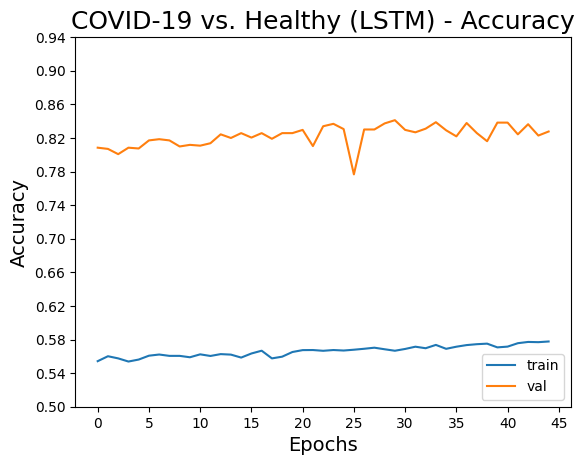

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy (LSTM) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.5, 0.96, 0.04))
plt.xticks(np.arange(0, 46, 5.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

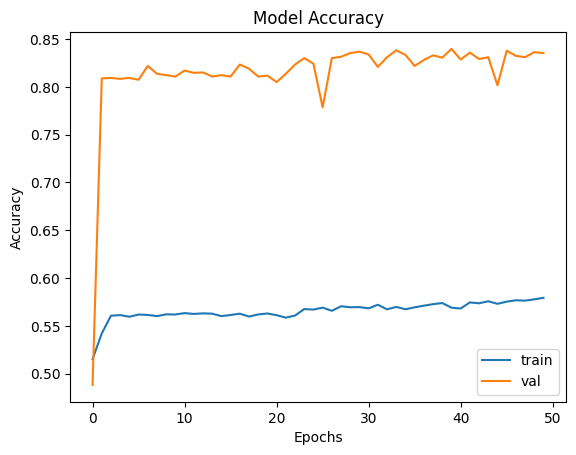

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [20]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 7s 98ms/step - loss: 0.5375 - accuracy: 0.8150


[0.5375497937202454, 0.8149913549423218]

In [21]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-06 08:35:37.004863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:37.205934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:37.222943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:38.467292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-06 08:35:38.481929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 87ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

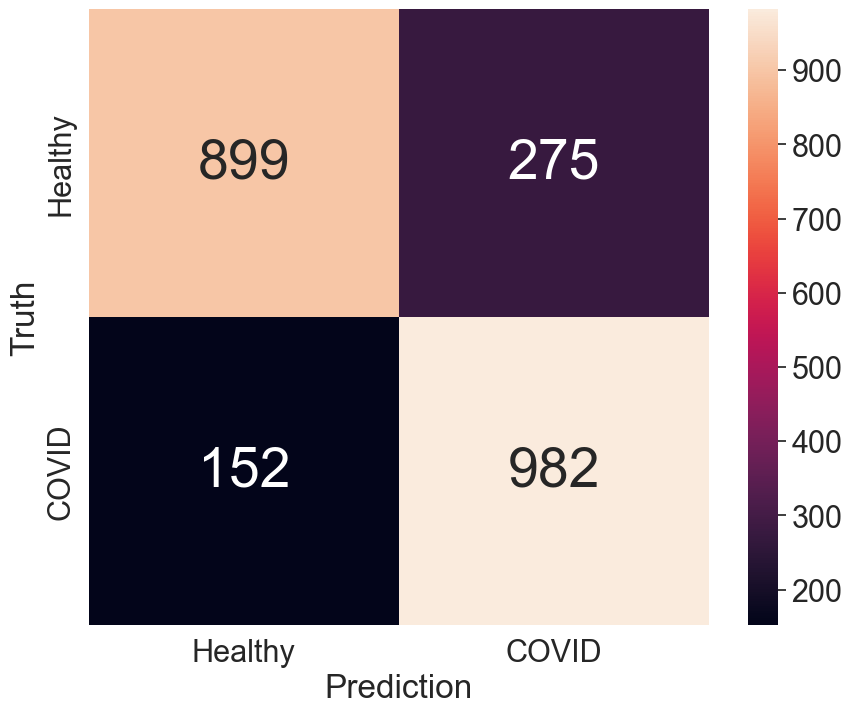

tf.Tensor(
[[899 275]
 [152 982]], shape=(2, 2), dtype=int32)


In [22]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [23]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

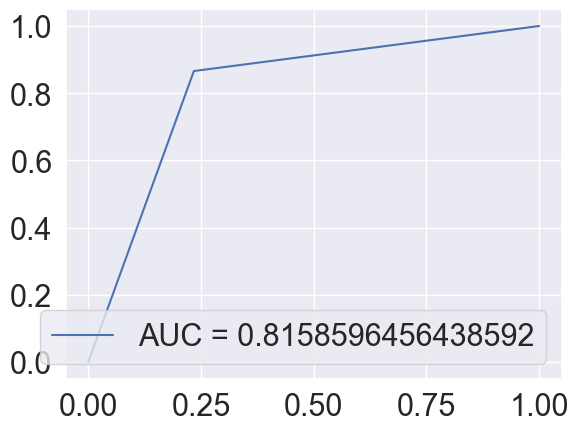

In [24]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# Model 2: CLS Embeddings

In [22]:
X = np.concatenate((healthy_cls_embeddings, covid_cls_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [23]:
del healthy_cls_embeddings
del covid_cls_embeddings
gc.collect()

0

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [25]:
del X
del y
gc.collect()

0

In [26]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_91 (Dropout)        (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_92 (Dropout)        (None, 128)               0

In [28]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-06 06:17:56.196062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-06 06:17:56.587659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.7970

2023-01-06 06:18:03.505328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 8s 12ms/step - loss: 0.4166 - accuracy: 0.7970 - val_loss: 0.3956 - val_accuracy: 0.8089
Epoch 2/50
585/585 [==============================] - 7s 12ms/step - loss: 0.3882 - accuracy: 0.8142 - val_loss: 0.3853 - val_accuracy: 0.8113
Epoch 3/50
585/585 [==============================] - 7s 11ms/step - loss: 0.3775 - accuracy: 0.8183 - val_loss: 0.3848 - val_accuracy: 0.8084
Epoch 4/50
585/585 [==============================] - 7s 11ms/step - loss: 0.3701 - accuracy: 0.8222 - val_loss: 0.3804 - val_accuracy: 0.8180
Epoch 5/50
585/585 [==============================] - 7s 11ms/step - loss: 0.3608 - accuracy: 0.8287 - val_loss: 0.3627 - val_accuracy: 0.8286
Epoch 6/50
585/585 [==============================] - 7s 11ms/step - loss: 0.3550 - accuracy: 0.8343 - val_loss: 0.3563 - val_accuracy: 0.8387
Epoch 7/50
585/585 [==============================] - 7s 11ms/step - loss: 0.3471 - accuracy: 0.8390 - val_loss: 0.3423 - val_accuracy: 0.8450
Epoch 8/50

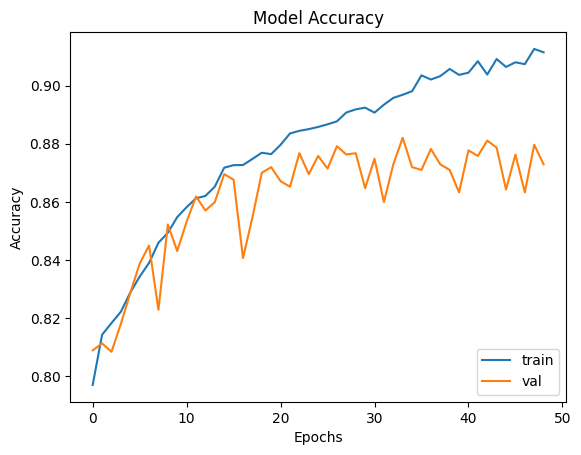

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 2 Testing

In [31]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 8ms/step - loss: 0.3082 - accuracy: 0.8847


[0.3082195520401001, 0.8847486972808838]

In [32]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-01-06 06:23:39.116666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

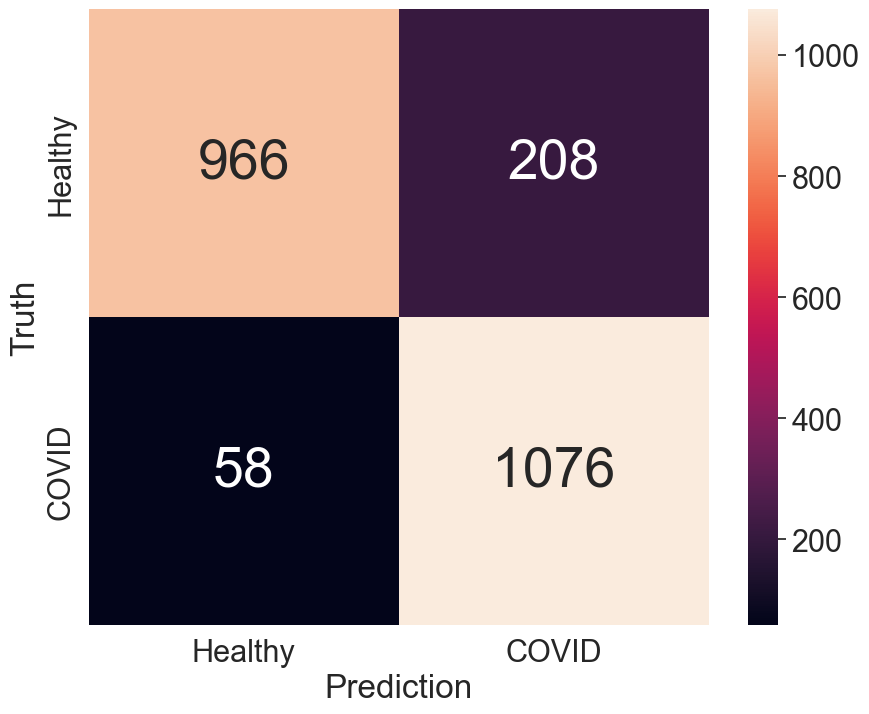

tf.Tensor(
[[ 966  208]
 [  58 1076]], shape=(2, 2), dtype=int32)


In [33]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [34]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

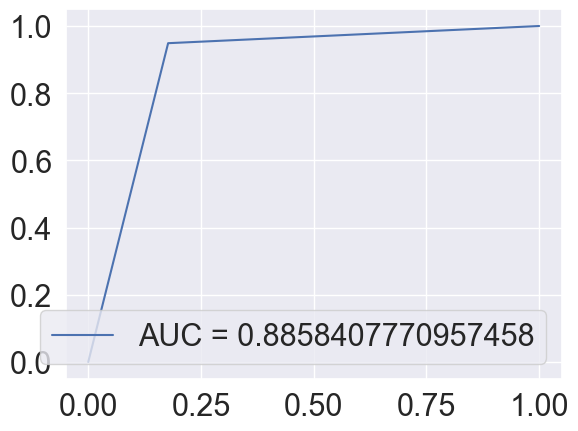

In [35]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# Model 3: Averaging Embeddings

In [11]:
X = np.concatenate((healthy_average_embeddings, covid_average_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [12]:
del healthy_average_embeddings
del covid_average_embeddings
gc.collect()

0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
# np.save("test", X_train)

In [15]:
del X
del y
gc.collect()

0

In [16]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-02 22:44:24.866789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 22:44:24.867007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                                                 
 dense_4 (Dense)             (None, 256)               9

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [19]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=150,
    mode='auto',
    restore_best_weights=True,
)

In [20]:
history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/1000


2023-02-02 22:44:25.374959: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 22:44:25.750332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.7724

2023-02-02 22:44:33.366643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 8s 13ms/step - loss: 0.4414 - accuracy: 0.7724 - val_loss: 0.4399 - val_accuracy: 0.7679
Epoch 2/1000
585/585 [==============================] - 8s 13ms/step - loss: 0.3647 - accuracy: 0.8188 - val_loss: 0.3356 - val_accuracy: 0.8358
Epoch 3/1000
585/585 [==============================] - 7s 13ms/step - loss: 0.3323 - accuracy: 0.8394 - val_loss: 0.3348 - val_accuracy: 0.8445
Epoch 4/1000
585/585 [==============================] - 7s 12ms/step - loss: 0.3207 - accuracy: 0.8490 - val_loss: 0.3148 - val_accuracy: 0.8445
Epoch 5/1000
585/585 [==============================] - 7s 13ms/step - loss: 0.3022 - accuracy: 0.8577 - val_loss: 0.3173 - val_accuracy: 0.8618
Epoch 6/1000
585/585 [==============================] - 7s 13ms/step - loss: 0.2944 - accuracy: 0.8620 - val_loss: 0.2875 - val_accuracy: 0.8662
Epoch 7/1000
585/585 [==============================] - 7s 12ms/step - loss: 0.2824 - accuracy: 0.8692 - val_loss: 0.2853 - val_accuracy: 0.874

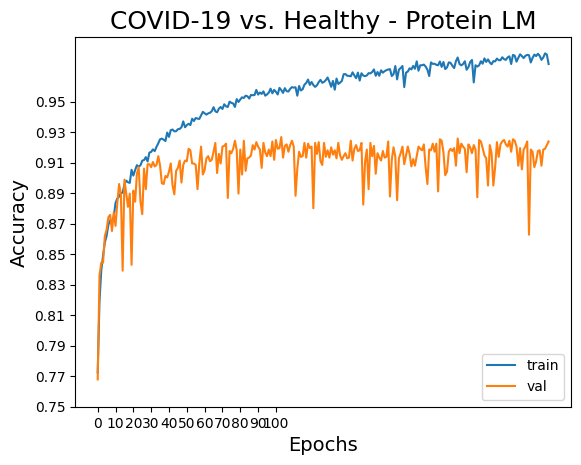

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy - Protein LM', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 0.96, 0.02))
plt.xticks(np.arange(0, 108, 10.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
with open('prot_bert_bfd_v2.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [22]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 13ms/step - loss: 0.2359 - accuracy: 0.9185


[0.23586240410804749, 0.9185441732406616]

In [22]:
model.save("prot_berd_bfd_v2.1.h5")

In [4]:
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[es])

NameError: name 'model' is not defined

## Model 3 Testing

In [5]:
# model.save("prot_berd_bfd_v2.h5")

In [6]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

In [20]:
model.evaluate(X_test, y_test)

10/73 [===>..........................] - ETA: 0s - loss: 0.2629 - accuracy: 0.9125 

2023-01-29 18:36:50.427330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 1s 6ms/step - loss: 0.2359 - accuracy: 0.9185


[0.23586240410804749, 0.9185441732406616]

In [7]:
model = tf.keras.models.load_model("prot_berd_bfd_v2.1.h5")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-02 16:24:52.258300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 16:24:52.258460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

NameError: name 'y_test' is not defined

In [9]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    COVID-19 vs. Healthy - Protein LM\n', fontsize=30)
sns.set(font_scale=3.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

NameError: name 'y_true' is not defined

In [ ]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

In [2]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

NameError: name 'sklearn' is not defined